## Calculating Temperature trends
---
**What are we doing:**
- 1970-2025 t2m trends for
    - tropical-mean land temperature trend (20S to 20N)
    - global-mean land temperature trend
    - global-mean land+ocean temperature trend
    - neotropics land temperature trend -- need mask for this

- Might be cool to look at zonal anomolies too

---

**Credit for WWF NeoTropical Masks**

WWF (2004) Simplified Biogeographical Realms of the World, generalised from Olson, D.M., E. Dinerstein, E.D. Wikramanayake, N.D. Burgess, G.V.N. Powell, E.C. Underwood, J.A. D’Amico, H.E. Strand, J.C. Morrison, C.J. Loucks, T.F. Allnutt, J.F. Lamoreux, T.H. Ricketts, I. Itoua, W.W. Wettengel, Y. Kura, P. Hedao, and K. Kassem. (2001). Terrestrial ecoregions of the world: A new map of life on Earth. BioScience 51(11):933-938. DOI: 10.1641/0006-3568(2001)051[0933:TEOTWA]2.0.CO;2.


In [ ]:
## Libs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import seaborn as sns
import regionmask

## Data Load:
STORAGE_PATH = "/gws/nopw/j04/global_ex/chingosa/ERA5_monthly/t2m.nc"    # Path to store downloaded data - change as needed
ds = xr.open_dataset(STORAGE_PATH)
ds['lsm'] = ds.lsm.isel(valid_time=0)

# load shapefile from WWF
gdf = gpd.read_file("brpol_fin_dd.shx")


---
### Defining regions


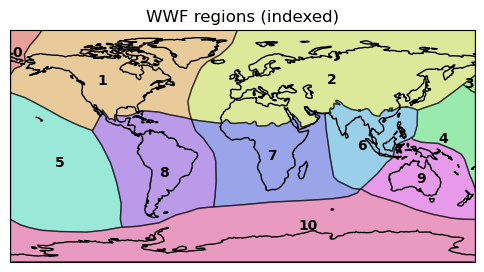

In [46]:
## Plot WWF regions with index
fig, ax = plt.subplots(1, 1, figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
palette = sns.color_palette("hls", len(gdf))

for i, (geometry, color) in enumerate(zip(gdf.geometry, palette)):
    # draw polygon
    ax.add_geometries([geometry], crs=ccrs.PlateCarree(), edgecolor='black', facecolor=color, linewidth=1, alpha=0.6,)

    point = geometry.representative_point()
    ax.text(point.x, point.y, str(i), fontsize=10, fontweight="bold", ha="center", va="center", transform=ccrs.PlateCarree())

ax.coastlines()
ax.set_title("WWF regions (indexed)")
plt.show()

## There might be an issue to do with 5/4 merging? not my problem -> just interested in 8

In [44]:
## Area Masks
#-------------------------------------------------------
# NeoTropics Land
regions = regionmask.Regions(outlines=gdf.geometry)
region_mask = regions.mask(ds)
mask_NeoTropics = region_mask == 8
lsm_mask = ds.lsm > 0.5
mask_NeoTropics = mask_NeoTropics & lsm_mask

# tropical Land
mask_tropical_land = ds.lsm.where((ds['latitude'] > -20) & (ds['latitude'] < 20)) > 0.5

# global all
mask_global_all = ds.lsm.notnull()

# global land
mask_global_land = ds.lsm > 0.5

masks = {
    "NeoTropics Land": mask_NeoTropics,
    "Tropical Land": mask_tropical_land,
    "Global All": mask_global_all,
    "Global Land": mask_global_land,
}

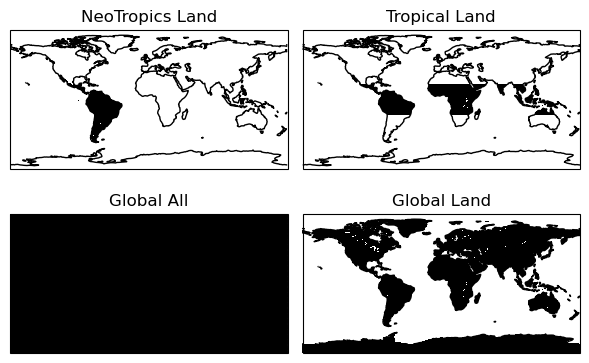

In [ ]:
# Sanity check area masks
fig, axes = plt.subplots(2, 2, figsize=(6, 4), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()
for ax, (name, mask) in zip(axes, masks.items()):
    mask.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="Greys", add_colorbar=False, vmin=0, vmax=1)
    ax.coastlines()
    ax.set_title(name)
plt.tight_layout()
plt.show()

---
### Calculating Temperature trends:

Follow a simple procedure:

- Compute area-weighted regional mean:
    - For each region mask, apply a cosine-of-latitude weight to account for the decreasing area toward the poles.
    - Mask the global temperature field (t2m) to the region of interest and compute the weighted mean over latitude and longitude.
- Deseasonalize monthly data:
    - Compute the long-term monthly climatology for the region.
    - Subtract the monthly climatology from the regional time series to remove the seasonal cycle, yielding monthly anomalies.
- Compute linear trend:
    - Fit a linear regression of the deseasonalized time series against time (converted to years).
    - Convert the slope to units of K per decade.
- Estimate uncertainty using block bootstrap:
    - Resample the deseasonalized time series in contiguous blocks (to preserve autocorrelation) and refit the trend for each bootstrap sample.
    - Calculate the median slope and the 5–95% confidence interval across all bootstrap samples.
- Store results:
    - Save the deseasonalized time series, raw trend, bootstrap median trend, and confidence intervals for plotting and analysis.

In [ ]:
## Function to calculate block bootstrap trend and 90% CI
def bootstrap_trend(anom, block=12, nboot=2000):
    ''''helper function to calculate block bootstrap trend and 90% CI'''
    y = anom.values
    n = len(y)
    t = np.arange(n) / 12.0

    good = np.isfinite(y)
    y = y[good]
    t = t[good]
    n = len(y)

    slopes = np.empty(nboot)

    for i in range(nboot):
        idx = []
        while len(idx) < n:
            start = np.random.randint(0, n - block)
            idx.extend(range(start, start + block))
        idx = np.array(idx[:n])

        # RESAMPLE BOTH t AND y
        coeff = np.polyfit(t[idx], y[idx], 1)
        slopes[i] = coeff[0] * 10  # K / decade     --> converted here

    return (
        np.median(slopes),             # median trend from bootstrap samples
        np.percentile(slopes, [5, 95]) # 90% CI
    )

In [ ]:

ts_anom = {}
trends = {}
trends_BS = {}
trends_BS_CI_upper = {}
trends_BS_CI_lower = {}
# latitude weights
weights = np.cos(np.deg2rad(ds.latitude))

for name, mask in masks.items():
    # masked area-weighted mean
    w = weights.where(mask)
    ts = (
        ds.t2m
        .weighted(w.fillna(0))
        .mean(dim=("latitude", "longitude"))
    )

    # deseasonalise (monthly)
    clim = ts.groupby("valid_time.month").mean("valid_time")
    anom = ts.groupby("valid_time.month") - clim
    anom_pM = ts.groupby("valid_time.month") - clim + clim.mean("month")
    ts_anom[name] = anom

    # linear trend (per year)
    t = np.arange(anom.sizes["valid_time"]) / 12.0
    coeff = np.polyfit(t, anom, 1)
    trends[name] = coeff[0] * 10  # K / decade  --> converted here for the polyfit trend calc (separate from bootstrap)

    # bootstrap trend CI
    slope, ci = bootstrap_trend(anom)
    trends_BS[name] = slope
    trends_BS_CI_lower[name] = ci[0]
    trends_BS_CI_upper[name] = ci[1]

# print results
print("\n-----------------------")
print("Linear Trends (K/decade):")
print("-----------------------")
for name, slope in trends.items():
    print(f"    {name}: {slope:.4f} K/decade")

print("\n-----------------------")
print("Bootstrap Trends with 90% CI (K/decade):")
print("-----------------------")
for name, slope in trends_BS.items():
    print(f"    {name}: {slope:.4f} K/decade; 90% CI: ({trends_BS_CI_lower[name]:.4f}, {trends_BS_CI_upper[name]:.4f})")

# Plot time series


-----------------------
Linear Trends (K/decade):
-----------------------
    NeoTropics Land: 0.2332 K/decade
    Tropical Land: 0.2640 K/decade
    Global All: 0.2127 K/decade
    Global Land: 0.3279 K/decade

-----------------------
Bootstrap Trends with 90% CI (K/decade):
-----------------------
    NeoTropics Land: 0.2379 K/decade; 90% CI: (0.2041, 0.2722)
    Tropical Land: 0.2681 K/decade; 90% CI: (0.2342, 0.3026)
    Global All: 0.2133 K/decade; 90% CI: (0.1933, 0.2325)
    Global Land: 0.3286 K/decade; 90% CI: (0.2996, 0.3582)


---
### Plotting up the bootstrapped CIs

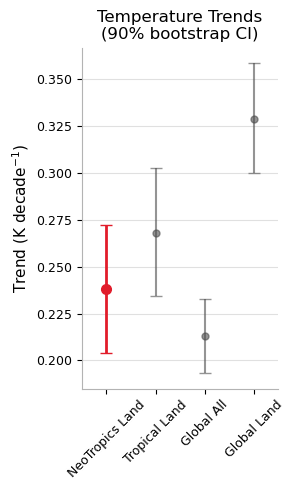

In [87]:
# nice colors
COL_GREY = "#4D4D4D"
COL_LIGHT_GREY = "#B3B3B3"
COL_RED = "#E11C2A"   

fig, ax = plt.subplots(figsize=(3, 5))

for name in trends_BS.keys():

    is_neo = "NeoTropics Land" in name  
    color = COL_RED if is_neo else COL_GREY
    alpha = 1.0 if is_neo else 0.6
    zorder = 3 if is_neo else 2
    ms = 7 if is_neo else 5
    lw = 2 if is_neo else 1.5

    ax.errorbar(
        name,
        trends_BS[name],
        yerr=[[trends_BS[name] - trends_BS_CI_lower[name]], [trends_BS_CI_upper[name] - trends_BS[name]]],
        fmt="o",
        color=color,
        ecolor=color,
        elinewidth=lw,
        capsize=4,
        markersize=ms,
        alpha=alpha,
        zorder=zorder,
    )

# Styling
ax.set_ylabel("Trend (K decade$^{-1}$)", fontsize=11)
ax.set_title("Temperature Trends\n(90% bootstrap CI)", fontsize=12)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_color(COL_LIGHT_GREY)
ax.spines["bottom"].set_color(COL_LIGHT_GREY)

ax.tick_params(axis="x", rotation=45, labelsize=9)
ax.tick_params(axis="y", labelsize=9)
ax.set_xlim(-0.5, len(trends_BS) - 0.5)
ax.grid(axis="y", color=COL_LIGHT_GREY, linewidth=0.8, alpha=0.4)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()


In [89]:
# ts_anom["NeoTropics Land"].rolling(valid_time=12).mean().plot()
# ts_anom["Tropical Land"].rolling(valid_time=12).mean().plot()
# ts_anom["Global All"].rolling(valid_time=12).mean().plot()
# ts_anom["Global Land"].rolling(valid_time=12).mean().plot()